# Project File - APS360 Team 25
Divided into the following section: 
# 
1) Library imports
2) Data imports
3) Model architecture definition
4) Training function definition
5) Model training
6) Model testing

## Library imports 
(Place all library imports here)

In [1]:
#KP - I just added the main ones from the labs.
import torch
import numpy as np

#import torchvision
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

import time # Tracking model training time.

#for Data importing
import mido
from mido import MidiFile, Message, MidiTrack, MetaMessage
import os
import random

In [2]:
#Set working directory if required:
os.chdir('D:\engsci\year 3\CLASS\APS360\Project') #Sets current working directory!

## Data imports
#### MIDI reading functions

In [3]:
def CountTracks(directory):          #Count files and tracks in folder
    trackCount = 0
    fileCount = 0
    for file in os.listdir(directory):
        if file.endswith(".midi"):
            fileCount += 1
            midiDir = MidiFile(directory+"/"+file)
            for track in midiDir.tracks:
                trackCount += 1
    print(fileCount+" files")
    print(trackCount+" tracks")

    
def PrintMessages(mid):                # print midi messages
    for i, track in enumerate(mid.tracks):
        print('Track {}: {}'.format(i, track.name))
        for msg in track:
            print(msg)

            
def PrintSomeMessages(mid):             #print first 200 midi messages
    track = mid.tracks[1]
    for i,msg in enumerate(track):
        if i < 200:
            print(msg)
            
def PrintMetaMessages(mid):             #print fmeta messages
    track = mid.tracks[0]
    for i,msg in enumerate(track):
        print(msg)

def cleanupMessages(mid):              #removes non-note messages by force
    track = mid.tracks[1]
    track2 = []
    for msg in track:
        if msg.type == "note_on":
            track2.append(msg)
    mid.tracks[1] = track2

#### MIDI to Numpy code

In [4]:

def Midi2NumpyNoSustain(mid):                                #converts to numpy array removing non-note messages
    track = mid.tracks[1]                           #0th track only contains meta-messages, all notes on 1st track
    notes = np.empty([0,4])
    time = 0
    for msg in track:
        if msg.type == "note_on":                   # only count "note" messages - other inputs i.e. foot pedals are ignored
            notes = np.append(notes,np.array([[msg.note, msg.velocity, msg.time + time, 0]]),axis=0)         # (note, velocity, time, sustain)
            time = 0
        else:
            time += msg.time                        #adjust time when removing other messages
    return notes


def NumpyGetSustain(note):
    notes = np.copy(note)
    for i, msg in enumerate(notes):
        if msg[1] > 0:                            # if velocity is not 0
            j = 1
            sustain = 0
            while msg[0] != notes[i+j][0]:        # while note values are different
                sustain += notes[i+j][2]
                j += 1                            #search for next message with same note i.e. message telling that note was released
            notes[i,3] = sustain + notes[i+j][2]
    time = 0
    for i, msg in enumerate(notes):
        if msg[1] > 0:
            notes[i,2] += time
            time = 0
        else:
            time += msg[2]                        #adjust time
    notes = notes[notes[:,1] > 0]                 #filter for notes with positive velocities (note presses)
    return notes

def NumpyNormalize(note, oneHot=False):                         #normalize all values to 0-1
    notes = np.copy(note)
    
    if oneHot:
        notes[:,12] /= 11
        notes[:,13] /= 128
        notes[:,14] /= 40000
        notes[:,15] /= 40000
    else:
        notes[:,0] /= 128
        notes[:,1] /= 128
        notes[:,2] /= 40000
        notes[:,3] /= 40000       
    return notes

def NumpyOneHot(note):
    notes = np.copy(note)
    oneHot = np.zeros([len(notes),16])
    oneHot[:, 13:] = notes[:, 1:]
    names = notes[:,0]
    namesOct = names%12
    oneHot[:,12] = (names-(namesOct))/12
    
    for i, name in enumerate(namesOct):
        oneHot[i,name.astype(int)] = 1
    
    return oneHot

def Midi2Numpy(path, oneHot=False): # full midi to numpy conversion
    mid = MidiFile(path)
    notes = Midi2NumpyNoSustain(mid)
    cleanNotes = NumpyGetSustain(notes)
    
    if oneHot:
        cleanNotes = NumpyOneHot(cleanNotes)
    
    normNotes = NumpyNormalize(cleanNotes, oneHot=oneHot)
    return normNotes

#### Numpy to MIDI code

In [5]:

def NumpyDenormalize(note): # interpret all values from 0-1 to normal values
    notes = np.copy(note)    
    if notes.shape[1] == 16: # if encode as one-hot
        notes[:,12] *= 11
        notes[:,13] *= 128
        notes[:,14] *= 40000
        notes[:,15] *= 40000
        
        notes = NumpyEncode(notes) #encode back as original 4-variable format
    else:
        notes[:,0] *= 128
        notes[:,1] *= 128
        notes[:,2] *= 40000
        notes[:,3] *= 40000       
    return notes.astype(int)

def NumpyEncode(note): # convert back from one-hot encoding
    notes = np.copy(note)
    encoded = np.zeros([len(notes),4])
    encoded[:, 1:] = notes[:, 13:]
    encoded[:, 0] = notes[:,12]*12
    
    for i in range(len(notes)):
        encoded[i,0] += np.argmax(notes[i,:12])
    
    return encoded

def NumpySequence(notes): # put all notes into a "timeline" i.e.: time values of [10, 20, 10, 30] become [10, 30, 40, 70]
    sequenced = np.copy(notes)                      # this allows us to easily add vel=0 notes in any order since we can later sort them by time
    for i, msg in enumerate(sequenced):
        if i > 0:
            sequenced[i,2] += sequenced[i-1,2]
    return sequenced

def NumpyAddOffNotes(sequenced): # add vel=0 notes from sustain into sequenced timeline
    withOff = np.copy(sequenced)
    for msg in sequenced:
        offNote = np.array([[msg[0], 0, msg[2] + msg[3], 0]])
        withOff = np.append(withOff, offNote, axis=0)
    #withOff = np.sort(withOff,axis=0)
    withOff = withOff[withOff[:,2].argsort()] # sort by time
    return withOff

def NumpyUnsequence(notes): # revert time value to "time since last message"
    unsequenced = np.copy(notes)
    for i, msg in reversed(list(enumerate(unsequenced))):
        unsequenced[i,3] = 0
        if i > 0:
            unsequenced[i,2] -= unsequenced[i-1,2]
    return unsequenced

def Numpy2MidiDirect(array):    #make MIDI object from numpy
    #Start with initializing a new Mido Track:
    mid = MidiFile()
    track0 = MidiTrack()
    track1 = MidiTrack()
    
    track0.append(MetaMessage('set_tempo', tempo=500000, time=0)) #MetaMessages not necessary but are present in used files
    track0.append(MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0))
    track0.append(MetaMessage('end_of_track', time=1))
    
    track1.append(Message('program_change', channel=0, program=0, time=0))
    
    for i,note in enumerate(array):         # Get the index and the note. Array must be int array
        j = 1
        track1.append(Message('note_on',note = array[i,0], velocity = array[i,1],time = array[i,2])) # Add the note to the track.

    mid.tracks.append(track0)
    mid.tracks.append(track1)
    return mid

def Numpy2Midi(notes, name): # full numpy to midi conversion, saving result to [name].midi
    denorm = NumpyDenormalize(notes)
    seq = NumpySequence(denorm)
    off = NumpyAddOffNotes(seq)
    unseq = NumpyUnsequence(off)
    mid = Numpy2MidiDirect(unseq)
    mid.save(name + ".midi")

#### Generating tensor dataset from CSVs

In [6]:
def Numpy2Dataset(notes,num=100,skip=10): # make list of sumpy arrays #Playing with window sized (num)
    samples = []
    i = 0
    while i+num <= len(notes):
        samples.append(notes[i:i+num])
        i += skip
    return samples

def SampleAllNumpy(dataPath): # generate samples from all saved CSVs
    allSamples = []

    for i,f in enumerate(os.listdir(dataPath)):
        
        
        if i % 1280 == 0:
            print(i)
            notes = np.genfromtxt(dataPath+f, delimiter=',') #Moved down... 
            allSamples += Numpy2Dataset(notes) #Moved down into if statement...
    
    return allSamples

def SaveSamplesTensor(samples, outputPath): # save tensor
    tens = torch.Tensor(samples)
    torch.save(samples, outputPath+"Notes_Dataset_test_onehot.pt")
    return tens   

def SaveAllSamples(dataPath, outputPath): # save dataset tensor
    samples = SampleAllNumpy(dataPath)
    SaveSamplesTensor(samples, outputPath)
    print('done')

#### Bulk data conversion code - COMMENT OUT IF NOT IN USE!!!

In [7]:
# SaveAllSamples("D:/engsci/year 3/CLASS/APS360/Project/data/numpy_files/","D:/engsci/year 3/CLASS/APS360/Project/data/") #save all into tensor

## Baseline Model Code
#### getting available notes

In [8]:
def GetAllNotesMajor(root):# Get all used notes in major scale of root=root
    notes = []
    intervals = [2,2,1,2,2,2,1]
    
    while root > 24: #bring down to lowest used octave
        root -= 12
    
    n = root
    notes.append(n)
    while n < 84: #up to higherst used note
        for i in intervals:
            n += i
            notes.append(n)   
    return notes    


def GetRangeMajor(notes, low, high): # Get all notes within range
    lowIndex = notes.index(low)
    highIndex = notes.index(high)
    
    return notes[lowIndex:highIndex+1]   

#### Piece Class
##### represents whole output from all 4 voices

In [9]:
class Piece: # Entire baseline model compostion - composed of 4 voices soprano, alto, tenor, bass (SATB)
    def __init__(self, barNum=16, root=60):# 16 bars in C major
        self.root = root # root note
        self.allNotes = GetAllNotesMajor(self.root) # all notes on major scale
        self.barNum = barNum # number of bars
        
        self.soprano = Voice(self.allNotes,60,84,speed=8) # SATB
        self.alto = Voice(self.allNotes,48,72)
        self.tenor = Voice(self.allNotes,36,60)
        self.bass = Voice(self.allNotes,24,48)
          
        self.notes = np.empty([0,4]) #notes output
        
        self.pieceChords = [] # chords
        
        self.chords = np.array([ # common classical C major chords
            [ 0,  4,  7,  0],# I
            [ 2,  5,  9,  2],# ii
            [ 4,  7, 11,  4],# iii
            [ 5,  9, 0,  5],# IV
            [ 7, 11, 2,  7],# V
            [ 9, 0, 4,  9],# vi
            [11, 2, 5, 11],# vii dim
            [ 2,  5,  9, 0],# ii7
            [ 5,  9, 0, 4],# IVmaj7
            [ 7, 11, 2, 5],# V7
            [11, 2, 5, 9]])# vii7 half-dim
        
    def GenerateSoprano(self): # Generate soprano line
        self.soprano.GenerateLine(self.soprano.speed*self.barNum)
        
    def GenerateAlto(self): # Generate alto line from chords
        self.alto.GenerateChordLine(self.pieceChords)
        
    def GenerateTenor(self): # see alto
        self.tenor.GenerateChordLine(self.pieceChords)
        
    def GenerateBass(self): # see alto
        self.bass.GenerateChordLine(self.pieceChords)
        
        
    
    def ChooseChord(self, sopNote): # Choose a fitting chord for soprano note
        while sopNote >= 12:
            sopNote -= 12
        
        goodChords = np.empty([0,4])
        
        for chord in self.chords:
            if (chord==sopNote).sum() > 0:
                goodChords = np.append(goodChords,[chord],axis=0)
        
        chosenChord = goodChords[random.randint(0,len(goodChords)-1)]
        chosenChord = np.sort(np.unique(chosenChord))
        
        i = 12
        chordNotes = chosenChord
        while i < 120:
            chordNotes = np.append(chordNotes, chosenChord+i)
            i += 12
        
        return(chordNotes)
    
    def GetChords(self): # select all chords in piece
        for i, note in enumerate(self.soprano.notes):
            if i % 2 == 0:
                sopNote = note[0]
                chord = self.ChooseChord(sopNote)
                self.pieceChords.append(chord)
                
    def GenerateLines(self): # Generate all SATB lines and joins them - entire baseline model
        self.GenerateSoprano()
        self.GetChords()
        self.GenerateAlto()
        self.GenerateTenor()
        self.GenerateBass()
        self.joinLines()
        
        self.notes = self.notes.astype(int)
        self.OffsetTime(20)
        
        return self.notes
        
    def InsertLine(self, starting, inserted, startIndex, skipIndex): # join 2 lines
        base = np.copy(starting)
        ins = np.copy(inserted)
        
        for i,note in enumerate(ins):
            base = np.insert(base, (i*skipIndex)+startIndex, [note], axis=0)
            
        return base
        
    def joinLines(self): # join all SATB lines
        #self.notes = np.copy(self.soprano)
        self.notes = self.InsertLine(self.soprano.notes, self.alto.notes, 1, 3)
        self.notes = self.InsertLine(self.notes, self.tenor.notes, 2, 4)
        self.notes = self.InsertLine(self.notes, self.bass.notes, 3, 5)
        
    def OffsetTime(self, maxChange): # adds random time offsets to make output more organic
        for note in self.notes:
            note[2] += random.randint(0,maxChange)
        

#### Voice class
##### Represents individual voices

In [10]:
class Voice: # individual voices
    def __init__(self, allNotes, lowNote, highNote, jump=3, speed=4, time=4096, velocity=64):
        self.range = GetRangeMajor(allNotes,lowNote,highNote) #available ntoes
        self.jump = jump #maximum pitch interval between notes
        self.speed = speed #note length i.e. 4 for quarter, 8 for eighth etc.
        self.time = time #song speed
        self.velocity = velocity #note volume
        self.notes = np.empty([0,4]) #notes output
        self.lowNote = lowNote # lowest note
        self.highNote = highNote # highest note
        self.allNotes = allNotes # all notes in scale
            
        self.duration = self.time / self.speed # time between notes
        
        
    def RandomStartNote(self): # Generate Random first note (for soprano)
        note = random.choice(self.range)
        self.notes = np.append(self.notes,np.array([[note, self.velocity, 0, self.duration]]),axis=0)
        
        
    def RandomJump(self): # Generate Random next note (for soprano)
        lastNote = self.notes[len(self.notes)-1][0] # find last played note
        lastIndex = self.range.index(lastNote)
        
        newIndex = -1
        while newIndex < 0 or newIndex >= len(self.range): # stay in range
            newIndex = lastIndex + random.randint(-self.jump,self.jump)
            
        newNote = self.range[newIndex]
        self.notes = np.append(self.notes,np.array([[newNote, self.velocity, self.duration, self.duration]]),axis=0)
        
        
    def GenerateLine(self, length): # Generate random line (for soprano)
        self.RandomStartNote()
        
        for n in range(length-1):
            self.RandomJump()
            
            
    def clearNotes(self):
        self.notes = np.empty([0,4])
        
    def GetChordNotes(self, chordNotes): # Get useful notes from all chord notes
        chordNotes = chordNotes[chordNotes >= self.lowNote]
        chordNotes = chordNotes[chordNotes <= self.highNote]
        return chordNotes
    
    def ChooseStartChordNote(self, chordNotes): # Choose Random note in chord
        note = random.choice(chordNotes)
        self.notes = np.append(self.notes,np.array([[note, self.velocity, 0, self.duration]]),axis=0)
        
    def ChooseChordNote(self,chordNotes): # Choose suitable next note in chord
        lastNote = self.notes[len(self.notes)-1][0] # find last played note
        
        chordNotes = chordNotes[chordNotes >= lastNote - (self.jump*2)]
        chordNotes = chordNotes[chordNotes <= lastNote + (self.jump*2)]
        newNote = random.choice(chordNotes)
        
        self.notes = np.append(self.notes,np.array([[newNote, self.velocity, 0, self.duration]]),axis=0)
        
    def GenerateChordLine(self, chords): # Generate A/T/B lines
        
        firstChord = self.GetChordNotes(chords[0])
        self.ChooseStartChordNote(firstChord)
        
        for c in chords[1:]:
            chord = self.GetChordNotes(c)
            self.ChooseChordNote(chord)

## Model architecture definition

Set the hyperparameters below:


In [11]:
#For LSTM: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM 
n1 = 1 #Number of input features
nh1 = 1 #Number of features in the hidden state h
nl1 = 1 #Number of layers in each LSTM calling (more than 1 stacks them with same number of hidden features).
dropout1 = 0 #Percentage dropout of each layer. I believe 0-->1 range.

n2 = 1 #Number of input features
nh2 = 1 #Number of features in the hidden state h
nl2 = 1 #Number of layers in each LSTM calling (more than 1 stacks them with same number of hidden features).
dropout2 = 0 #Percentage dropout of each layer. I believe 0-->1 range.

In [12]:
# torch.manual_seed(1000) #Set the manual seed so that we get reproducible results.

# #Define the RNNMusicGenerator model below:
# class RNNMusicGenerator(nn.Module): 
#     def __init__(self):
#         super(RNNMusicGenerator, self).__init__()
#         self.name = "MusicGen"
#         self.LSTM1 = nn.LSTM(input_size = n1, hidden_size = nh1,num_layers = nl1, batch_first = True,dropout = dropout1)
#         #^^Expects data as: (batch_size,sequence,features)
#         self.LSTM2 = nn.LSTM(input_size = n, hidden_size = nh,num_layers = nl, batch_first = True,dropout = dropout)
#         #unsure of the output dimensions still...
#     def forward(self, x):
#         x = (F.relu(self.LSTM1(x)))
#         x = self.LSTM2(x) #No activation function on second layer for now...
#         return x
    
# print('Model class created succesfully')

# Regression based model

In [13]:
class RNNMusicGenerator(nn.Module): #GRU based
    def __init__(self, input_size = 16, hidden_size = 512,num_layers = 3):
        super(RNNMusicGenerator, self).__init__()
        self.name = "LSTM_Reg_ws20_simple_model"
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(self.input_size, self.hidden_size,num_layers, batch_first = True, 
                           bidirectional = True,dropout = 0.3)

#         self.rnn1 = nn.LSTM(self.hidden_size, self.hidden_size, batch_first = True,num_layers = num_layers)
#         self.rnn1 = nn.LSTM(self.hidden_size, self.hidden_size, batch_first = True)
        #^^Expects data as: (batch_size,sequence,features)
        self.linear1 = nn.Linear(self.hidden_size*2, 256)
#         self.linear2 = nn.Linear(32,16)
        self.linear = nn.Linear(256, self.input_size) #Regression problem.
        self.dropout = nn.Dropout(0.3)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2,x.size(0),self.hidden_size)
        
        c0 = torch.zeros(self.num_layers*2,x.size(0),self.hidden_size)
        if use_cuda and torch.cuda.is_available():
            c0 = c0.cuda()
            h0 = h0.cuda()
            
        out,_ = self.rnn(x,(h0,c0))
      

        
#         h1 = torch.zeros(self.num_layers,out.size(0),self.hidden_size)
#         c1 = torch.zeros(self.num_layers,out.size(0),self.hidden_size)
#         out,(h1,c1) = self.rnn1(out,(h1,c1))
#         h1 = torch.zeros(1,x.size(0),self.input_size)
#         c1 = torch.zeros(1,x.size(0),self.input_size)
#         out,(h0,c0) = self.rnn1(out,(h0,c0))
#         out = F.relu(out)
#         out,(h0,c0) = self.rnn1(out,(h0,c0))
#         print(output.shape)
#         out = F.relu(out)
#         output,_ = self.RNN2(output,(None,None)) #No activation function on second layer for now...
#         print(hidden)    
#         out = self.linear1(out[:,-1,:])
#         out = self.linear(out) #Takes the last one...
#         out = F.relu(out)
#         out = self.linear2(out)
#         out = F.relu(out)
#         out = torch.cat([torch.max(out, dim=1)[0], 
#                  torch.mean(out, dim=1)], dim=1)
        pred = self.dropout(self.linear1(torch.max(out,dim=1)[0])) #Takes the last one...
        pred = F.relu(pred)
        pred = self.dropout(self.linear(pred))
    #Combine outputs (see lab 5 or others --> OR take flattened output).
        pred = torch.sigmoid(pred) #To prevent negative values.
        #For one hot:
#         pred[:,14] = pred[:,14].copy()**6
#         pred[:,14] = pred1
        return pred
    
print('Model class created succesfully')

Model class created succesfully


# One-Hot encoding

## Training function

In [14]:
#To help us save the model easier...
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path


In [15]:
def train_network(model,data,ws,data_size, num_epochs=20, batch_size=1, learning_rate=1e-5): #Learning rate is really small... Push it up...
    torch.manual_seed(1000) #Fixed. Make sure we use this throughout...
    criterion = nn.MSELoss() # mean square error loss. Compares reconstruction errors entry by entry. For regression.
    optimizer = torch.optim.Adam(model.parameters(), #Try different ones...
                                 lr=learning_rate) # <-- Sometimes Adam converges faster than SGD #Don't worry about weight decay here...
#     train_loader = torch.utils.data.DataLoader(data, 
#                                                batch_size=batch_size, 
#                                                shuffle=True) #Using train_loader wasn't working and was uneeded.
    
    iters, losses, train_acc, val_acc, epochs = [], [], [], [], []
    
    n = 0 # the number of iterations
    start_time=time.time() #Start of training.
    outputs = []
    
    for epoch in range(num_epochs):
        model.train() #Enable dropout layers...
        for i in range(len(data)//batch_size): #Batch using indexes...
#             sample = sample.unsqueeze(0) #RNN structure needs (batch_first...)
            sample = data[i:i+batch_size]
            if use_cuda and torch.cuda.is_available():
                sample = sample.cuda()
#             print(sample.shape)
#             print(type(sample))
            excerpt = sample[:,:-1,:] # Extracts all but the last row (model will predict last note)
#             print('excerpt.shape: ',excerpt.shape)
            true_note = sample[:,-1,:] # Extracts the last row (what we want it to predict).
#             print(true_note)
#             print('true_note.shape: ',true_note.shape)
            pred_note = model(excerpt) # Collects next note prediction. #Throw out the hidden layer. Only from -1->1... Why?
            # Round to nearest integers
#             pred_note = pred_note.type(torch.int)
            
#             print(type(pred_note))
#             print('pred_note.shape: ',pred_note.shape)
#             print(pred_note.reshape(-1,4).shape, ' ',true_note.reshape(-1).shape)
            loss = criterion(pred_note, true_note) #pred_note gets spit out as (batch,1,4)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() # Clean up, clean up, everybody, everywhere...

                
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            if not n%10:
                
                print('Iteration:{}, Loss:{:.4f}'.format(n, float(loss)))
            
            n += 1
#         train_acc.append(get_accuracy(model, data)) # compute training accuracy
        epochs.append(epoch)
        model.eval() #Disable dropouts. For get_accuracy stuffs
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
#         print('Epoch:{}, Loss:{:.4f}, train_acc:{}'.format(epoch+1, float(loss),train_acc[epoch]))
        print('predicted note: ',pred_note)
        outputs.append((epoch, true_note, pred_note),)
      #Checkpoint the model every epoch
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch) #Returns the model name for 
      #the save file.
        print('model_path: ',model_path)
        torch.save(model.state_dict(), model_path) #Saves the current model with the weights.
        print('model checkpointed')
    end_time= time.time()
    
    
      # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.savefig('Loss_plot_ws_{}_n_epochs_{}_batch_size_{}_learning_rate_{}_data_size_{}.pdf'.format(ws,epoch,batch_size,learning_rate,data_size))
    plt.show()

#     plt.title("Training Curve")
#     plt.plot(epochs, train_acc, label="Train")
# #     plt.plot(iters, val_acc, label="Validation")
#     plt.xlabel("Iterations")
#     plt.ylabel("Training Accuracy")
#     plt.savefig('Accuracy_plot_ws_{}_n_epochs_{}_batch_size_{}_learning_rate_{}_data_size_{}.pdf'.format(ws,epoch,batch_size,learning_rate,data_size))
#     plt.legend(loc='best')
#     plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
#     print("Final Validation Accuracy: {}".format(val_acc[-1]))
    return True

In [16]:
def train_network_one_hot(model,data,ws,data_size, num_epochs=20, batch_size=1, learning_rate=1e-3): #Learning rate is really small... Push it up...
    torch.manual_seed(1000) #Fixed. Make sure we use this throughout...
    criterion = nn.MSELoss() # mean square error loss. Compares reconstruction errors entry by entry. For regression.
    optimizer = torch.optim.Adam(model.parameters(), #Try different ones...
                                 lr=learning_rate) # <-- Sometimes Adam converges faster than SGD #Don't worry about weight decay here...
#     train_loader = torch.utils.data.DataLoader(data, 
#                                                batch_size=batch_size, 
#                                                shuffle=True) #Using train_loader wasn't working and was uneeded.
    
    iters, losses, train_acc, val_acc, epochs = [], [], [], [], []
    data_iter = torch.utils.data.DataLoader(data,batch_size = batch_size)
    n = 0 # the number of iterations
    start_time=time.time() #Start of training.
    outputs = []
    
    for epoch in range(num_epochs):
        for sample,target in data_iter: #Batch using indexes...
#             sample = sample.unsqueeze(0) #RNN structure needs (batch_first...)
            if use_cuda and torch.cuda.is_available():
                sample = sample.cuda()
#             print(sample.shape)
#             print(type(sample))

            pred_note = model(sample) # Collects next note prediction. #Throw out the hidden layer. Only from -1->1... Why?
            # Round to nearest integers
#             pred_note = pred_note.type(torch.int)
            
#             print(type(pred_note))
#             print('pred_note.shape: ',pred_note.shape)
#             print(pred_note.reshape(-1,4).shape, ' ',true_note.reshape(-1).shape)
            loss = criterion(pred_note, target) #pred_note gets spit out as (batch,1,4)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() # Clean up, clean up, everybody, everywhere...

                
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            if not n%10:
                
                print('Iteration:{}, Loss:{:.4f}'.format(n, float(loss)))
            
            n += 1
#         train_acc.append(get_accuracy(model, data)) # compute training accuracy
        epochs.append(epoch)
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
#         print('Epoch:{}, Loss:{:.4f}, train_acc:{}'.format(epoch+1, float(loss),train_acc[epoch]))
#         print('predicted note: ',pred_note)
        outputs.append((epoch, target, pred_note),)
      #Checkpoint the model every epoch
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch) #Returns the model name for 
      #the save file.
        print('model_path: ',model_path)
        torch.save(model.state_dict(), model_path) #Saves the current model with the weights.
        print('model checkpointed')
    end_time= time.time()
    
    
      # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.savefig('Loss_plot_ws_{}_n_epochs_{}_batch_size_{}_learning_rate_{}_data_size_{}.pdf'.format(ws,epoch,batch_size,learning_rate,data_size))
    plt.show()

#     plt.title("Training Curve")
#     plt.plot(epochs, train_acc, label="Train")
# #     plt.plot(iters, val_acc, label="Validation")
#     plt.xlabel("Iterations")
#     plt.ylabel("Training Accuracy")
#     plt.savefig('Accuracy_plot_ws_{}_n_epochs_{}_batch_size_{}_learning_rate_{}_data_size_{}.pdf'.format(ws,epoch,batch_size,learning_rate,data_size))
#     plt.legend(loc='best')
#     plt.show()

#     print("Final Training Accuracy: {}".format(train_acc[-1]))
#     print("Final Validation Accuracy: {}".format(val_acc[-1]))
    return True

In [17]:
def train_network_onehot_manual_batching(model,data,ws,data_size, num_epochs=20, batch_size=1, learning_rate=1e-5): #Learning rate is really small... Push it up...
    torch.manual_seed(1000) #Fixed. Make sure we use this throughout...
    criterion = nn.MSELoss() # mean square error loss. Compares reconstruction errors entry by entry. For regression.
    optimizer = torch.optim.Adam(model.parameters(), #Try different ones...
                                 lr=learning_rate) # <-- Sometimes Adam converges faster than SGD #Don't worry about weight decay here...
#     train_loader = torch.utils.data.DataLoader(data, 
#                                                batch_size=batch_size, 
#                                                shuffle=True) #Using train_loader wasn't working and was uneeded.
    
    iters, losses, train_acc, val_acc, epochs = [], [], [], [], []
    
    n = 0 # the number of iterations
    start_time=time.time() #Start of training.
    outputs = []
    
    for epoch in range(num_epochs):
        model.train() #Enable dropout layers...
        for i in range(len(data)//batch_size): #Batch using indexes...
#             sample = sample.unsqueeze(0) #RNN structure needs (batch_first...)
            sample = data[i:i+batch_size]
            if use_cuda and torch.cuda.is_available():
                sample = sample.cuda()
#             print(sample.shape)
#             print(type(sample))
            excerpt = sample[:,:-1,:] # Extracts all but the last row (model will predict last note)
#             print('excerpt.shape: ',excerpt.shape)
            true_note = sample[:,-1,:] # Extracts the last row (what we want it to predict).
#             print(true_note)
#             print('true_note.shape: ',true_note.shape)
            pred_note = model(excerpt) # Collects next note prediction. #Throw out the hidden layer. Only from -1->1... Why?
            # Round to nearest integers
#             pred_note = pred_note.type(torch.int)
            
#             print(type(pred_note))
#             print('pred_note.shape: ',pred_note.shape)
#             print(pred_note.reshape(-1,4).shape, ' ',true_note.reshape(-1).shape)
            loss = criterion(pred_note, true_note) #pred_note gets spit out as (batch,1,4)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() # Clean up, clean up, everybody, everywhere...

                
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            if not n%10:
                
                print('Iteration:{}, Loss:{:.4f}'.format(n, float(loss)))
            
            n += 1
#         train_acc.append(get_accuracy(model, data)) # compute training accuracy
        epochs.append(epoch)
        model.eval() #Disable dropouts. For get_accuracy stuffs
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
#         print('Epoch:{}, Loss:{:.4f}, train_acc:{}'.format(epoch+1, float(loss),train_acc[epoch]))
        print('predicted note: ',pred_note)
        outputs.append((epoch, true_note, pred_note),)
      #Checkpoint the model every epoch
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch) #Returns the model name for 
      #the save file.
        print('model_path: ',model_path)
        torch.save(model.state_dict(), model_path) #Saves the current model with the weights.
        print('model checkpointed')
    end_time= time.time()
    
    
      # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.savefig('Loss_plot_ws_{}_n_epochs_{}_batch_size_{}_learning_rate_{}_data_size_{}.pdf'.format(ws,epoch,batch_size,learning_rate,data_size))
    plt.show()

#     plt.title("Training Curve")
#     plt.plot(epochs, train_acc, label="Train")
# #     plt.plot(iters, val_acc, label="Validation")
#     plt.xlabel("Iterations")
#     plt.ylabel("Training Accuracy")
#     plt.savefig('Accuracy_plot_ws_{}_n_epochs_{}_batch_size_{}_learning_rate_{}_data_size_{}.pdf'.format(ws,epoch,batch_size,learning_rate,data_size))
#     plt.legend(loc='best')
#     plt.show()

#     print("Final Training Accuracy: {}".format(train_acc[-1]))
#     print("Final Validation Accuracy: {}".format(val_acc[-1]))
    return True

In [18]:
def get_accuracy(model, data): #Accuracy on note selection...
    correct = 0
    total = 0
    data_loader = torch.utils.data.DataLoader(data, 
                                               batch_size=1, 
                                               shuffle=True)
    for sample in data: #Set a break point, don't do the whole set...
        if use_cuda and torch.cuda.is_available():
            sample = sample.cuda()
        sample = sample.unsqueeze(0)
#         print(sample)
        excerpt = sample[0:1,:-1] # Extracts all but the last row (model will predict last note)
#             print(excerpt.shape)
        true_note = sample[0:1,-1] # Extracts the last row (what we want it to predict).
#             print(true_note)
#             print('true_note.shape: ',true_note.shape)
        pred_note = model(excerpt) # Collects next note prediction. #Throw out the hidden layer. Only from -1->1... Why?
#         print(pred_note[0][0])
        #select index with maximum prediction score
        if abs(pred_note[0][0] - true_note[0][0]) < 1e-2: #Won't ever be 'perfect', but can set a threshold difference...
#             print('correct predictions!')
            print(pred_note[0][0])
            print(true_note[0][0])
            correct += 1
        total += 1
    return correct / total

## Model Training

86
Iteration:0, Loss:0.2203
Epoch:1, Loss:0.2203
predicted note:  tensor([[0.5044, 0.5000, 0.5211,  ..., 0.4700, 0.4767, 0.5070],
        [0.5134, 0.5020, 0.5126,  ..., 0.4831, 0.5000, 0.5050],
        [0.5000, 0.4967, 0.5000,  ..., 0.4722, 0.4791, 0.5000],
        ...,
        [0.5000, 0.4922, 0.5000,  ..., 0.5000, 0.5000, 0.5138],
        [0.5085, 0.4956, 0.5179,  ..., 0.4764, 0.4757, 0.5092],
        [0.5000, 0.4930, 0.5000,  ..., 0.4715, 0.4803, 0.5000]],
       grad_fn=<SigmoidBackward>)
model_path:  model_LSTM_Reg_ws20_simple_model_bs86_lr0.001_epoch0
model checkpointed
Epoch:2, Loss:0.2165
predicted note:  tensor([[0.5047, 0.4846, 0.5000,  ..., 0.4698, 0.4696, 0.4955],
        [0.5016, 0.4833, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5050,  ..., 0.4783, 0.5000, 0.4961],
        ...,
        [0.5058, 0.4841, 0.5052,  ..., 0.4682, 0.4674, 0.5000],
        [0.5084, 0.4904, 0.5122,  ..., 0.4741, 0.4772, 0.5063],
        [0.5034, 0.5000, 0.5075,  ..., 0.4827,

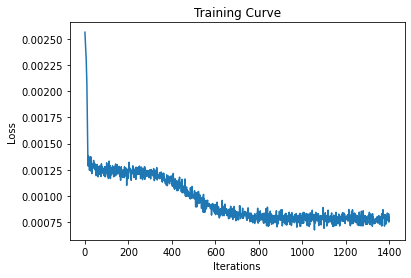

True

In [21]:
#Larger window size is better
#On-hot encoding...

use_cuda = False

model = RNNMusicGenerator(input_size = 16, hidden_size = 128,num_layers = 1) #Need to save sample #Bigger step (learning rate)
#32 did better than 64
if use_cuda and torch.cuda.is_available():
    model = model.cuda()
    
data = torch.load(r'D:\engsci\year 3\CLASS\APS360\Project\data\one_hot\Notes_Dataset_test_onehot_ws200.pt') #Will take a moment to load...
#Notes_Dataset_overfit: Has window sizes of 5... May be too small. Will try with 10
#the 'r' in the front is a requirement...
data = torch.tensor(data).float() #This line prevents an error.
# for sample,label in data:
#     print(data)
#     print('sample: ',sample)
#     print(sample.shape)
#     print('label: ',label)
#     print(label.shape)
#     break
print(len(data))
# print(torch.tensor(data))

train_network_onehot_manual_batching(model,data,batch_size = 86,num_epochs = 1400,learning_rate = 1e-3,ws = 20,data_size='bidirectional_512hidden_3layers') #Need very small learning_rate to avoid model learning standard note.
#Too large of a learning_rate value and it converges to average value. Too small and it converges to smaller one.
#I ignore batch_size...

In [ ]:
# Change the learning rate to be smaller...
train_network_onehot_manual_batching(model,data,batch_size = 256,num_epochs = 100,learning_rate = 1e-2,ws = 20,data_size='onehot_train_hidden_size=128_1layer,bidirectional') #Need very small learning_rate to avoid model learning standard note.


In [ ]:
print(model)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

In [ ]:
#To do: Implement model loading...

## Model Testing

Since our model is 'tested' with people listening to it, we need to just generate some samples.
To do so, and because this is a regression style problem, sampling will not be needed. Instead, we will feed it a random set of starting notes from a sample of music.

TO DO: Modify for 100 notes.

In [22]:
#Using random noise inputs:

def gen_sample(model,set_type,song_length,dataset,sample_selector):
    i = 0
    model.eval()

    test_data = torch.load(r'D:\engsci\year 3\CLASS\APS360\Project\data\one_hot\{}.pt'.format(dataset))

    if set_type == True:
        test_loader = torch.utils.data.DataLoader(test_data, 
                                               batch_size=1, 
                                               shuffle=True)

        for sample,target in test_loader:
            if i == sample_selector:

                x = sample # (Batch_size,sequence,notes) --> Must match the model layer input. Want it to give me small positive values!
                if use_cuda and torch.cuda.is_available():
                    x = x.cuda()
                break
            i += 1
        print('x.shape: ',x.shape)
    else:
        test_data = torch.tensor(test_data).float() #Uncomment for non-one hot
        for i in range(len(test_data)): #Batch using indexes...
            if i == sample_selector:

                x = test_data[i:i+1] # (Batch_size,sequence,notes) --> Must match the model layer input. Want it to give me small positive values!
                if use_cuda and torch.cuda.is_available():
                    x = x.cuda()
                break
            i += 1

    print(x)

    #Need to apply like softmax then maximize the one hot values to get proper notes...
    #See how the functions deal with non-valid inputs...

 #How many new notes we want the model to generate.
    
    start = True

    for t in range(0,song_length): #Generates t new notes.
        new_sample = model(x)
    #     print(new_sample.shape)
        new_sample[:,14] = new_sample[:,14]
        if start:
    #         print(new_sample.shape)
            new_sample = new_sample.unsqueeze(0)
    #         print(new_sample.shape)
            new_excerpt = torch.cat((x[:,1:,:],new_sample),1) #initializes new_excerpt as the random noise + new note
            start = False
    #         print(new_excerpt.shape)
            x = new_excerpt
    #         print(x)
        else:
            new_sample = new_sample.unsqueeze(0)
            new_excerpt = torch.cat((new_excerpt,new_sample),1)
    #         print(new_sample.shape)
            x = torch.cat((x[:,1:,:],new_sample),1) #Update x by throwing out the first note in the sequence and shoving the new note to the end.
    #         print(x)


    # print(new_excerpt.shape)
    print('%% generator loop done %%')
    # print(new_excerpt.shape)
    # print('new excerpt type: ',type(new_excerpt))
    new_excerpt = new_excerpt.detach().numpy()
    # new_excerpt = new_excerpt.type(torch.int64)
    print('new excerpt: (Watch for the same notes appearing...)',new_excerpt)
    new_excerpt = np.array(new_excerpt[0])
    print('new_excerpt.shape: ',new_excerpt.shape)
    return new_excerpt

In [29]:
new_excerpt = gen_sample(model,set_type=False,song_length = 1000,dataset='Notes_Dataset_test_onehot_ws100',sample_selector = 10)

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.9219e-01,
          1.2250e-02, 8.2250e-03],
         [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.8906e-01,
          5.0000e-04, 6.2500e-03],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.3594e-01,
          2.5000e-05, 7.8250e-03],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.3750e-01,
          2.9250e-03, 1.4250e-03],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.1406e-01,
          2.7000e-03, 1.4250e-03],
         [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.7656e-01,
          2.3000e-03, 2.2000e-03]]])
%% generator loop done %%
new excerpt: (Watch for the same notes appearing...) [[[1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.8906250e-01
   5.0000002e-04 6.2500001e-03]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 3.3593750e-01
   2.4999999e-05 7.8250002e-03]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.6562500e-01
   2.5000001e-04 4.1999999e-03]
  ...
  [1.5628129e-05 3.5

In [31]:

mid = Numpy2Midi(np.array(new_excerpt),'test_from_model_102_bidirectional_128hiddenunits_1LSTMlayer_ws200_prelrchange_secondone_250epochs,change every 100')